In [1]:
%matplotlib inline
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
from cdms2 import MV2
from genutil import statistics


pjr.py complete


test latex syntax $a = b^2$

In [2]:

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;

# a useful function for interpolating model to new levels
def getZAMP (fspec, vname, levs):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one
    #lat1 = fspec['lat']
    #lon1 = fspec['lon']
    #lev1 = fspec['lev']

    #Fxav = cdutil.averager(F,axis="x")
    #print "Txav=", Txav.info()

    ps = fspec('PS',squeeze=1)
    hyam = fspec('hyam',squeeze=1)
    hybm = fspec('hybm',squeeze=1)

    start = timer()
    P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
    P = P/100.; P.units = "hPa"
#    print "P info", P.info()
    stop1 = timer()
#    print  "reconstruct P time = ", stop1-start
#    FP1s = cdutil.logLinearInterpolation(F,P,levels=levs)
#    print "FP1s info", FP1s.info()
    pcol = levs
    nz, ny, nx = P.data.shape
    nznew = pcol.shape[0]
    pnew = np.repeat(pcol,nx*ny).reshape((nznew,ny,nx)); pold = P.data
    pnew = np.log(pnew); pold = np.log(P.data)
    #print "pnew",pnew.shape
    #print "newcol", pnew[:,0,0]
    ynew = pjr.interp_along_axis(F.data, pold, pnew, axis=0, inverse=False, method='linear')
    #print "ynew", ynew.shape
    #print "ynew00", ynew[:,0,0]
    nlevs = cdms2.createAxis(pcol,id="plev")
#    print "F info", F.info()
    FP1 = F.pressureRegrid(nlevs)
#    print "FP1 info", FP1.info()
    #print "missing val", FP1.missing_value
    llist = (FP1 > 0.9*FP1.missing_value) 
    FP1.data[:] = ynew
    FP1.mask = np.isnan(ynew) | llist
    stop2 = timer()
    #print "interp time", stop2-stop1

    #print "FP1.info", FP1.info()
    FP1xav = cdutil.averager(FP1,axis="x")
    return FP1xav;

def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TP0 = T0.pressureRegrid(nlevs) # vertical regrid
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    TP0 = TP0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    # vertical regridding seems to lose the mask so add one back in
    list = (TP0 > 0.9*TP0.missing_value) 
    TP0.mask = list # make sure the missing vales are masked
    TP0xav = cdutil.averager(TP0,axis="x")
    levsp0 = TP0xav.getAxis(0)
    lat0 = TP0xav.getAxis(1)

    TP1xav = getZAMP (g1, vname, levs)
    levsp1 = TP1xav.getAxis(0)
    lat1 = TP1xav.getAxis(1)
#    print "TP1xav info", TP1xav.info()
    
    TP2xav = getZAMP (g2, vname, levs)
    levsp2 = TP2xav.getAxis(0)
    lat2 = TP2xav.getAxis(1)

    orig_bounds = cdms2.getAutoBounds()
    #print "autobounds", orig_bounds
    cdms2.setAutoBounds(1)
    #print "autobounds set"

    lat1 = TP1xav.getAxis(1)
    lbnd =lat1.getBounds()
#    print "lbnd", lbnd.shape,lbnd[0:4,1], lbnd[0:4,0]
    myywts = (np.sin(lbnd[:,1]*np.pi/180.)-np.sin(lbnd[:,0]*np.pi/180.))*0.5
#    print "myywts", myywts.shape, myywts[0:4]

    #dlat = lbnd[:,1]-lbnd[:,0]
    #print "dlat", dlat[0:4]
    levsp1 = TP1xav.getAxis(0)
    # looks like CDMS puts bounds halfway between dimension values,
    # and then does something reasonable with the endpoints
    bnd=levsp1.getBounds()
#    print "bnd.shape", bnd.shape
#    print "cdms guess at bnd", bnd
    db = bnd[:,1]-bnd[:,0]
#    print "db", db[0:4]

    #print "db.shape", db.shape, db.sum()
    #1./0.
    levsp1.setBounds(bnd)
    # overwrite the default bounds with my version
    #levsp1.setBounds(lev_bnds)
    #print "lev_bnds 2", lev_bnds[0:4]
    #bnd=levs1.getBounds()
    #print "bnd 2", bnd
    #db = bnd[:,1]-bnd[:,0]
    #print "db 2", db[0:4]
    #print "levs1 db",db[0:4]
    cdms2.setAutoBounds(orig_bounds)
    #print "autobounds unset"
    #print "autobounds3", cdms2.getAutoBounds()

    levwts = db
    #levwts[:] = 1.
    #levwts = levwts/levwts.sum()
    print "levwts.sum", levwts.dtype, levwts.sum()
    print "levwts", levwts[0:4]

    #print "help T1xav", help(T1xav)
    tweights = TP1xav.copy()
    #print "tw info", tweights.info()

    weights = MV2.outerproduct(levwts, myywts)
    print "levwts[0],latwts[0],product", levwts[0], myywts[0], levwts[0]*myywts[0]
    tweights.data[:] = weights.data[:]
    tweights.id = 'tweights'

    DT2xav = TP2xav - TP0xav
    DT1xav = TP1xav - TP0xav
    
    cor02 = statistics.correlation(TP2xav, TP0xav, axis='yz')
    cor01 = statistics.correlation(TP1xav, TP0xav, axis='yz')
    rms02 = statistics.rms(TP2xav, TP0xav, axis='yz')
    rms01 = statistics.rms(TP1xav, TP0xav, axis='yz')
    print "rms (uncentered, biased) rms02, rms01", rms02, rms01
    print "corr (centered, biased) cor02, cor01", cor02, cor01

    cor02w = statistics.correlation(TP2xav, TP0xav,weights=tweights, axis='yz')
    cor01w = statistics.correlation(TP1xav, TP0xav, weights=tweights,axis='yz')
    rms02w = statistics.rms(TP2xav, TP0xav, weights=tweights,axis='yz')
    rms01w = statistics.rms(TP1xav, TP0xav, weights=tweights,axis='yz')
    print "weighted rms (uncentered, biased) rms02, rms01", rms02w, rms01w
    print "weighted corr (centered, biased) cor02, cor01", cor02w, cor01w
    
#    cor02 = statistics.correlation(TP2xav, TP0xav, axis='yz', centered=0)
#    cor01 = statistics.correlation(TP1xav, TP0xav, axis='yz', centered=0)
#    rms02 = statistics.rms(TP2xav, TP0xav, axis='yz', centered=1)
#    rms01 = statistics.rms(TP1xav, TP0xav, axis='yz', centered=1)
#    print "rms (centered, biased) rms02, rms01", rms02, rms01
#    print "corr (uncentered, biased) cor02, cor01", cor02, cor01

#    cor02 = statistics.correlation(TP2xav, TP0xav, axis='yz', biased=0)
#    cor01 = statistics.correlation(TP1xav, TP0xav, axis='yz', biased=0)
#    rms02 = statistics.rms(TP2xav, TP0xav, axis='yz', biased=0)
#    rms01 = statistics.rms(TP1xav, TP0xav, axis='yz', biased=0)
#    print "rms (uncentered, unbiased) rms02, rms01", rms02, rms01
#    print "corr (centered, unbiased) cor02, cor01", cor02, cor01

    DT1xav.rms = rms01w
    DT2xav.rms = rms02w
    DT1xav.cor = cor01w
    DT2xav.cor = cor02w
    
    return TP0xav, DT1xav, DT2xav;

def pltdat (T0xav, T1xav, T2xav, dlevs=None):

    fig = plt.figure(figsize=(5., 10.), facecolor='white')
    axest = fig.add_subplot(311)
    axesm = fig.add_subplot(312)
    axesb = fig.add_subplot(313)
    crng = np.array([T0xav.min(),T1xav.min(),T0xav.max(), T1xav.max()])
    clevx = pjr.findNiceContours(crng,20)
    if dlevs is None:
        drng = np.array([T2xav.min(),T2xav.max()])
        dlevs = pjr.findNiceContours(drng, 20, rmClev=0., sym=True)
    print "diff contour levs", dlevs

    rtit0 = "Min/Max %6.1f"%T0xav.min()+"/%6.1f"%T0xav.max() # 
    rtit1 = "Min/Max %6.1f"%T1xav.min()+"/%6.1f"%T1xav.max() # 
    rtit2 = "Min/Max %7.2g"%T2xav.min()+"/%7.2g"%T2xav.max() #

    cmap = plt.cm.viridis_r
    pjr.plotZMf(T0xav, T0xav.getAxis(1), T0xav.getAxis(0), plotOpt={'cmap':cmap,'ltitle':T0xav.long_name,'rtitle':rtit0,'clevs':clevx,'cabv':'grey','cbel':'orange','colorbar':'right'}, axesa=axest) 
    pjr.plotZMf(T1xav, T1xav.getAxis(1), T1xav.getAxis(0), axesa=axesm,fig=fig,plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevx,'cmap':cmap,'cabv':'grey','colorbar':'rightnd'})
    cmap = pjr.diverge_map()
    pjr.plotZMf(T2xav, T2xav.getAxis(1), T2xav.getAxis(0), axesa=axesb,fig=fig,plotOpt={'ltitle':ltit2,'rtitle':rtit2,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'right'})
    plt.tight_layout(pad=0, w_pad=0.0, h_pad=1.0)

    # show plot
    #plt.show()
    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname


levs [ 150.  200.  250.  300.  350.  400.  450.  500.  550.  600.  650.  700.
  750.  800.  850.  900.  950. 1000.]



 seas JJA
jname1 /Users/d3x345/Netcdf_Files/vd05_JJA_climo.nc
jname2 /Users/d3x345/Netcdf_Files/vd05_JJA_climo.nc
diff contour levs [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]
ZAVG_Temperature_JJA_test.pdf complete


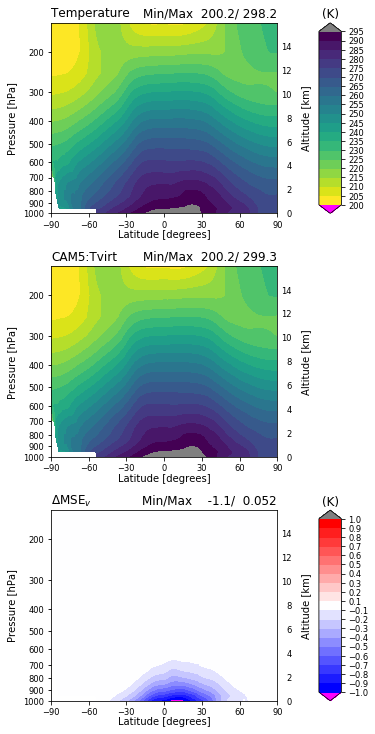

In [5]:
# main driver cell

# identify the levels that we will interpolate to
levs = pjr.findNiceContours(np.array([1000.,100]),30,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs,id="plev") # make a cdms vertical grid to remap to

#----------------------------------------------------------
# define the metadata that controls the analysis and plotting
# the season to plot
seaslist = ["ANN","JJA","DJF"]
seaslist = ["ANN"]
seaslist = ["JJA"]

# the dictionary of contour levels to use for particular field differences
dlevdict = {'RELHUM':np.array([-30.,-20.,-10.,-5.,5.,10.,20.,30.]),
            'T':np.array([-10.,-8.,-6.,-4.,-2.,-1.,1.,2.,4.,6.,8.,10.]),
            'U':np.array([-20.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,20.])}


# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
#vlist.append(vsets("Relative Humidity", "RELHUM","hur"))
vlist.append(vsets("Temperature", "T", "ta"))
#vlist.append(vsets("Zonal Wind", "U", "ua"))

initdone = False
for seas in seaslist:
    print "\n\n\n seas", seas

    ltit0 = "ltit0"
    ltit2 = "$\Delta$MSE$_v$"
    # model1 dataset
    dir1 = "/Users/d3x345/Netcdf_Files/"
    f1 = "vd05_"+seas+"_climo.nc"

    jname1 = dir1+f1
    print "jname1", jname1
    jname2 = jname1
    print "jname2", jname2  

    g1 = cdms2.open(jname1);
    g2 = cdms2.open(jname2)

    for i in vlist:
        vname = "Tvirt"
        ltit1 = "CAM5:"+vname
        pltname = "ZAVG_"+i.name+"_"+seas+"_test.pdf"
        Txav = getZAMP (g1, "T", levs)
        #print "T info", Txav.info()
        Qxav = getZAMP (g1, "Q", levs)

        T0 = 273.16
        CPLIQ = 4220. # J/Kg/K @ T0 
        CPVAP = 1870. # J/Kg/K @ T0
        CPAIR = 1005.7 # J/kg/K
        L0 = 2.501e6 # J/Kg @T0
        LVAP = L0 + (CPVAP-CPLIQ)*(Txav-T0)
        T1xav = Txav + (LVAP-L0)*Qxav/CPAIR
#        TP0xav, DT1xav, DT2xav = getdat(g0, i.oname, g1, g2, i.mname)
#        dlevs = dlevdict.get(i.mname,None)
#        print "i.mname, dlevs", i.mname, dlevs
        DTxav = T1xav - Txav
#        print "DTxav range", DTxav.min()
        pltdat(T1xav, Txav, DTxav)
        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        print pltname+" complete"